# 7 Modeling<a id='5_Modeling'></a>

## 7.1 Contents<a id='7.1_Contents'></a>
* [7 Modeling](#7_Modeling)
  * [7.1 Contents](#7.1_Contents)
  * [7.2 Introduction](#7.2_Introduction)
  * [7.3 Imports](#7.3_Imports)
  * [7.4 Load Model](#7.4_Load_Model)
  * [7.5 Load Data](#7.5_Load_Data)
  * [7.6 Refit Model On All Available Data (excluding Florida Hospital)](#7.6_Refit_Model_On_All_Available_Data_(excluding_Florida_Hospital))
  * [7.7 Calculate Expected Price From The Model](#7.7_Calculate_Expected_Procedure_Price_Using_Florida_Hospital_From_The_Model)
  * [7.8 Random Florida Hospital](#7.8_Random_Florida_Hospital_In_Insurance_Market_Context)
    * [7.8.1 Procedure price](#7.8.1_Procedure_price)
    * [7.8.2 Infection Ratings](#7.8.2_Infection_Ratings)
    * [7.8.3 Hospitals per 100k](#7.8.3_Hospitals_per_100k)
    * [7.8.4 Discharges per 100k](#7.8.4_Discharges_per_100k)
    * [7.8.5 Discharge Ratio](#7.8.5_Discharge_Ratio)
    * [7.8.6 Bed Ratio](#7.8.6_Bed_Ratio)
    * [7.8.7 Interns/Residents](#7.8.7_Interns_Residents)
    * [7.8.8 Hospital Days](#7.8.8_Hospital_Days)
  * [7.9 Modeling scenarios](#7.9_Modeling_scenarios)
    * [7.9.1 Scenario 1](#7.9.1_Scenario_1)
    * [7.9.2 Scenario 2](#7.9.2_Scenario_2)
    * [7.9.3 Scenario 3](#7.9.3_Scenario_3)
    * [7.9.4 Scenario 4](#7.9.4_Scenario_4)
  * [7.10 Summary](#7.10_Summary)
  * [7.11 Further work](#7.11_Further_work)


## 7.2 Introduction<a id='7.2_Introduction'></a>

In this notebook, we now take our model for pricing and leverage it to gain some insights into what price of a random Florida hospital might actually support as well as explore the sensitivity of changes to various resort parameters. Note that this relies on the implicit assumption that all other resorts are largely setting prices based on how much people value certain facilities. 
In addition, from our previous notebook we can see that our accuracy from this model is not the highest, at 79%, so please take this analysis with a grain of salt. I will address this in the conclusion.

## 7.3 Imports<a id='7.3_Imports'></a>

In [166]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor

## 7.4 Load Model<a id='7.4_Load_Model'></a>

In [167]:
expected_model_version = 1
model_path = '../models/procedure_pricing_model.pkl'
if os.path.exists(model_path):
    with open(model_path, 'rb') as f:
        model = pickle.load(f)
    if model.version != expected_model_version:
        print("Expected model version doesn't match version loaded")
    if model.sklearn_version != sklearn_version:
        print("Warning: model created under different sklearn version")
else:
    print("Expected model not found")

## 7.5 Load Data<a id='7.5_Load_Data'></a>

In [168]:
path = 'data'
obj = os.scandir(path)
l = [entry for entry in obj]
df_dict = {}

for entry in l:
    p = entry.name[0:-8]
    df_dict[p] = pd.read_parquet('data/'+entry.name, engine='pyarrow')

# This is the same procedure we used in the previous notebook
procedure = 'CPT58150'
data = df_dict[procedure]
data= pd.get_dummies(data, columns=['Rural Versus Urban'], drop_first= True)

Lets pick a random Florida Hospital given it has the most hospitals within our list of procedures.

In [169]:
data[data['State Code']=='FL'].head(10).T

,4,41,55,56,57,58,59,60,61,62
ccn,100168,100017,100113,100007,100008,100025,100275,100014,100154,100088
State Code,FL,FL,FL,FL,FL,FL,FL,FL,FL,FL
PSI_03,2.915921,3.963068,0.152801,0.451683,1.088026,0.56465,1.014029,0.102825,2.909586,0.309567
PSI_06,0.197895,0.29655,0.196235,0.15857,0.14698,0.162348,0.164185,0.170671,0.19117,0.1719
PSI_08,0.062805,0.102285,0.051783,0.141355,0.039195,0.035636,0.052801,0.060561,0.053377,0.051546
PSI_09,3.227263,2.070166,2.868181,2.069424,2.648538,1.609382,2.264156,2.44553,2.154023,2.055427
PSI_10,3.064857,0.697059,1.497456,0.309488,1.251359,0.521601,1.220638,0.905268,0.770713,0.872126
PSI_11,10.679905,3.956092,4.306264,6.004977,21.444327,1.316736,6.008137,5.029652,7.361188,10.026066
PSI_12,5.43422,2.940722,4.79363,3.707826,5.046361,2.668187,3.857384,3.597614,4.063738,4.33491
PSI_13,5.74758,4.029735,6.27489,5.758861,5.108392,2.616165,4.752644,4.641143,4.318098,4.963131


Hospital CCN 10025 looks like a good hospital to pick, it seems to be in the middle of the pack for most features.

In [170]:
ccn_num = 100025
florida_hospital = data[data['ccn']== ccn_num]

In [171]:
florida_hospital.T

,58
ccn,100025
State Code,FL
PSI_03,0.56465
PSI_06,0.162348
PSI_08,0.035636
PSI_09,1.609382
PSI_10,0.521601
PSI_11,1.316736
PSI_12,2.668187
PSI_13,2.616165


## 7.6 Refit Model On All Available Data (excluding Florida Hospital)<a id='7.6_Refit_Model_On_All_Available_Data_(excluding_Florida_Hospital)'></a>

In [172]:
model.X_columns

['PSI_03',
 'PSI_06',
 'PSI_08',
 'PSI_09',
 'PSI_10',
 'PSI_11',
 'PSI_12',
 'PSI_13',
 'PSI_14',
 'PSI_15',
 'PSI_90',
 'HAI_1_SIR',
 'HAI_2_SIR',
 'HAI_3_SIR',
 'HAI_5_SIR',
 'HAI_6_SIR',
 'Number of Interns and Residents (FTE)',
 'Number of Beds',
 'Total Discharges (V + XVIII + XIX + Unknown)',
 'Total Days (V + XVIII + XIX + Unknown) + Total for all Subproviders',
 'Hospital Total Days (V + XVIII + XIX + Unknown) For Adults &amp; Peds',
 'Hospital Total Bed Days Available For Adults &amp; Peds',
 'Hospital Total Discharges (V + XVIII + XIX + Unknown) For Adults &amp; Peds',
 'state population',
 'median salary',
 'total hospitals',
 'total beds',
 'total discharges',
 'hospitals_per_100kcapita',
 'beds_per_100kcapita',
 'discharges_per_100kcapita',
 'hospital_ratio',
 'bed_ratio',
 'discharge_ratio',
 'Rural Versus Urban_U']

This next step requires some careful thought. We want to refit the model using all available data. We are going to exclude one Florida Hospital for our analysis, taking on the hospital as if it is our own. Let us ignore that hospital and recreate our model. 

In [173]:
X = data.loc[data['ccn'] != ccn_num, model.X_columns]
y = data.loc[data['ccn'] != ccn_num, 'negotiated_rates_median']

In [174]:
model.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestregressor',
                 RandomForestRegressor(max_depth=90, max_features='sqrt',
                                       min_samples_leaf=4, min_samples_split=10,
                                       n_estimators=400, random_state=42))])

In [175]:
cv_results = cross_validate(model, X, y, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [176]:
cv_results['test_score']

array([-262.41638915, -284.29016771, -241.32562331, -295.43618748,
       -253.76136154])

In [177]:
mae_mean, mae_std = np.mean(-1 * cv_results['test_score']), np.std(-1 * cv_results['test_score'])
mae_mean, mae_std

(267.4459458388133, 19.80917451622114)

These values from the model seem to be about the same from the model we created in the prior notebook.

## 7.7 Calculate Expected Procedure Price Using Florida Hospital From The Model<a id='7.7_Calculate_Expected_Procedure_Price_Using_Florida_Hospital_From_The_Model'></a>

In [178]:
X_bm = data.loc[data['ccn'] == ccn_num, model.X_columns]
y_bm = data.loc[data['ccn'] == ccn_num, 'negotiated_rates_median']

In [179]:
bm_pred = model.predict(X_bm).item()

In [180]:
y_bm = y_bm.values.item()

In [181]:
print(f'Florida Hospital modeled price is ${bm_pred:.2f}, actual price is ${y_bm:.2f}.')
print(f'Even with the expected mean absolute error of ${mae_mean:.2f}.')

Florida Hospital modeled price is $1392.49, actual price is $1427.87.
Even with the expected mean absolute error of $267.45.


The price is within or MAE, and our model predicts a slightly lower price. Let us see if we can improve our pricing from the hospital perspective.

## 7.8 Random Florida Hospital In Insurance Market Context<a id='5.8_Random_Florida_Hospital_In_Insurance_Market_Context'></a>

Features that came up as important in the modeling included:
* PSI_15
* HAI_2_SIR
* hospitals_per_100kcapita
* discharges_per_100kcapita
* bed_ratio
* discharge_ratio
* Number of Interns and Residents (FTE)

Some of these features are within the hospitals control, others are not. For example, PSI and HAI scores are easier to control and our interest for this analysis. The other metrics are more demand metrics and hospitals/discharges per 100k capita are state statistic, which hospitals have little agency to control.

In [182]:
def plot_compare(feat_name, description, state=None, figsize=(10, 5)):
    """Graphically compare distributions of features."""
    
    plt.subplots(figsize=figsize)
    if state is None:
        data_x = data[feat_name]
    else:
        data_x = data.loc[data['State Code'] == state, feat_name]
    data_x = data_x[np.isfinite(data_x)]
    plt.hist(data_x, bins=30)
    plt.axvline(x=florida_hospital[feat_name].values, c='r', ls='--', alpha=0.8, label='Florida Hospital')
    plt.xlabel(description)
    plt.ylabel('frequency')
    plt.title(description + ' distribution for hospitals')
    plt.legend()

### 7.8.1 Procedure price<a id='7.8.1_Procedure_price'></a>

Look at where Florida Hospital sits overall amongst all resorts for price on this procedure and for just other hospitals in Florida.

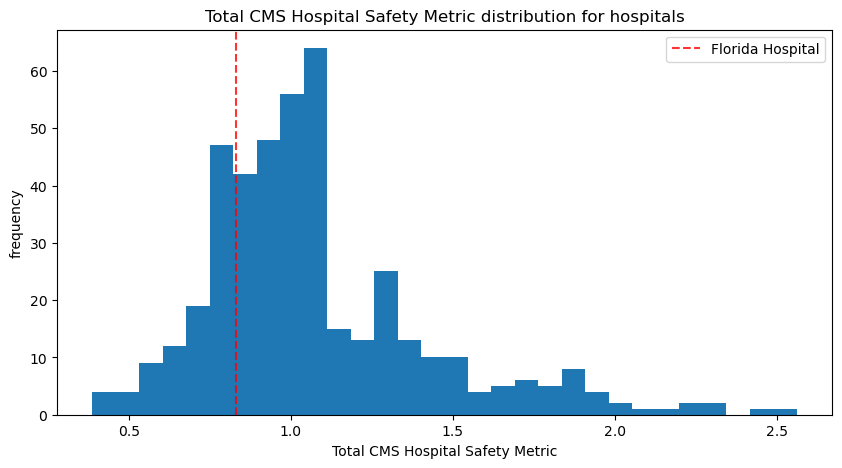

In [183]:
plot_compare('PSI_15', 'Total CMS Hospital Safety Metric')

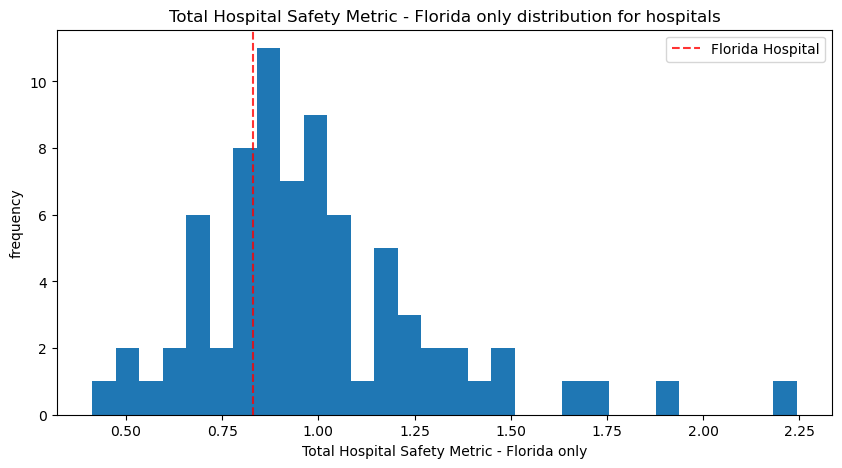

In [184]:
plot_compare('PSI_15', 'Total Hospital Safety Metric - Florida only', state='FL')

Our random hospital is near the average, slightly lower than most hospital within the US and even in the state of Florida.

### 7.8.2 Infection Ratings<a id='7.8.2_Infection_Ratings'></a>

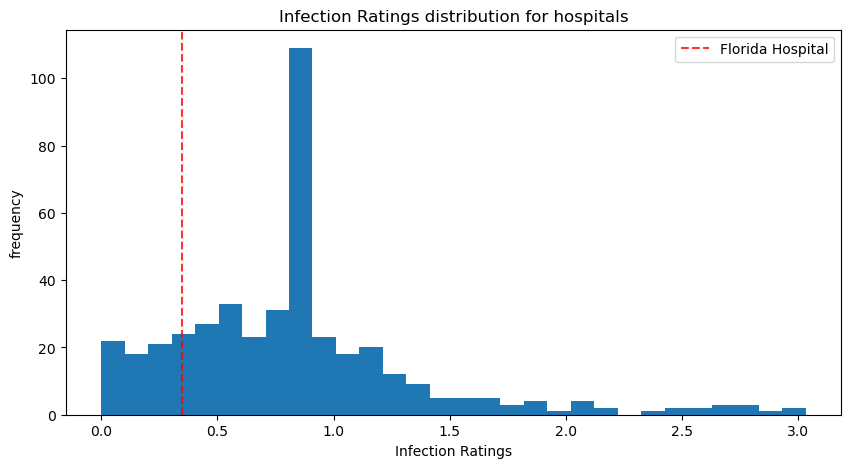

In [185]:
plot_compare('HAI_2_SIR', 'Infection Ratings')

Infection rating is below average, which is a good thing. (Higher SIR equals more infections per procedure.)

### 7.8.3 Hospitals per 100k<a id='7.8.3_Hospitals_per_100k'></a>

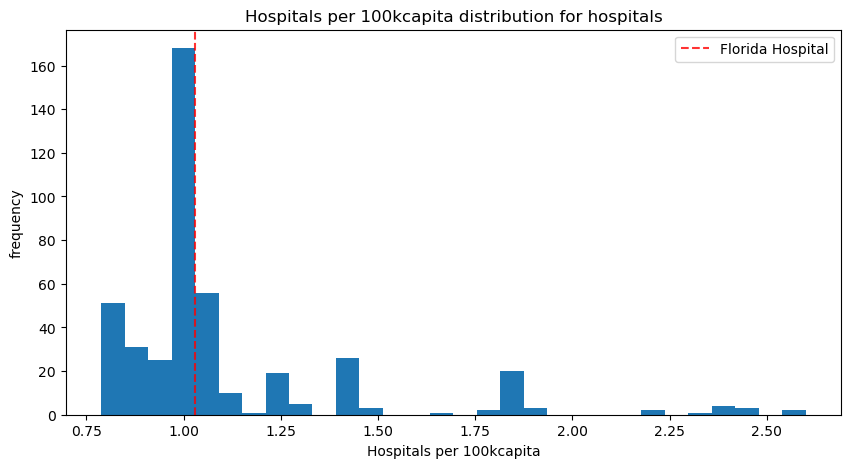

In [186]:
plot_compare('hospitals_per_100kcapita', 'Hospitals per 100kcapita')

Not surprising that our hospital lies with the mode here seeing that Florida hospitals are the most within our dataset and this is a state feature.

### 7.8.4 Discharges per 100k <a id='7.8.4_Discharges_per_100k'></a>

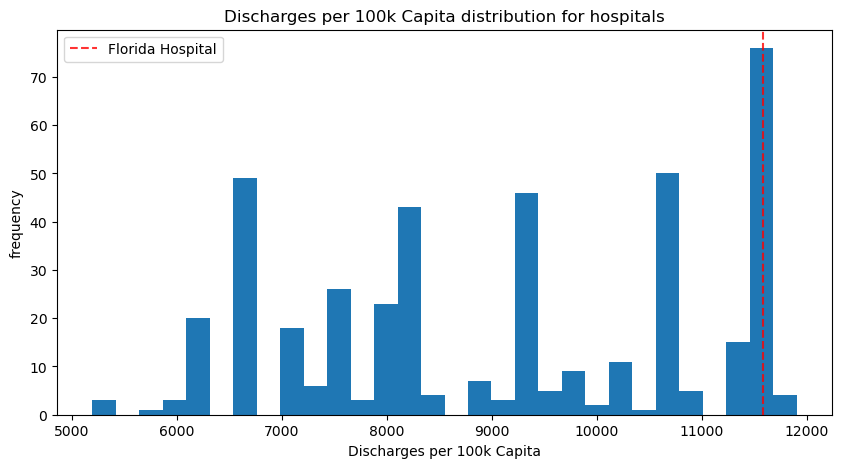

In [187]:
plot_compare('discharges_per_100kcapita', 'Discharges per 100k Capita')

Just like the above feature, not surprising that our hospital lies with the mode here seeing that Florida hospitals are the most within our dataset and this is a state feature.

### 7.8.5 Discharge Ratio<a id='7.8.5_Discharge_Ratio'></a>

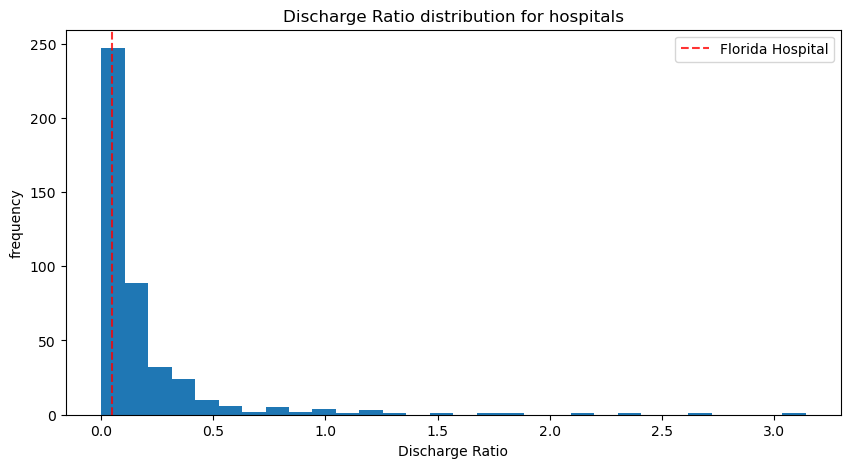

In [188]:
plot_compare('discharge_ratio', 'Discharge Ratio')

Since our hospital is in a large/populous state- this ratio is going to be small.

### 7.8.6 Bed Ratio<a id='7.8.6_Bed_Ratio'></a>

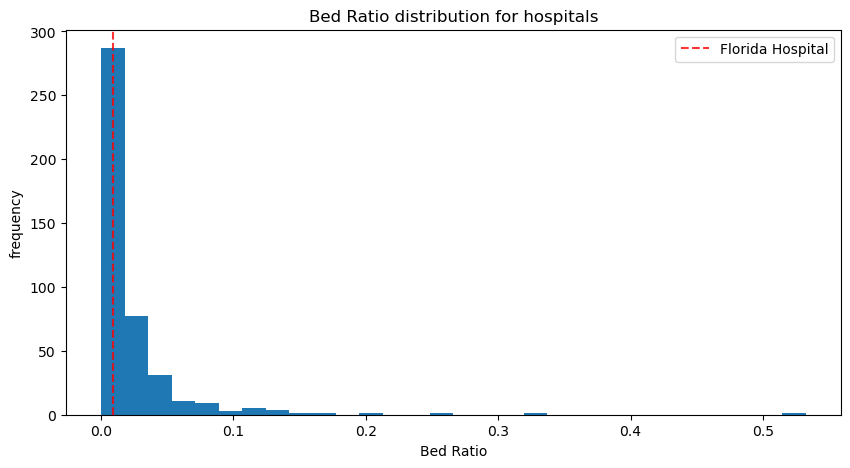

In [189]:
plot_compare('bed_ratio', 'Bed Ratio')

This is the same as the previous feature. Florida has numerous hospitals, so it is going to have a low bed ratio.

### 7.8.7 Interns/Residents<a id='7.8.7_Interns_Residents'></a>

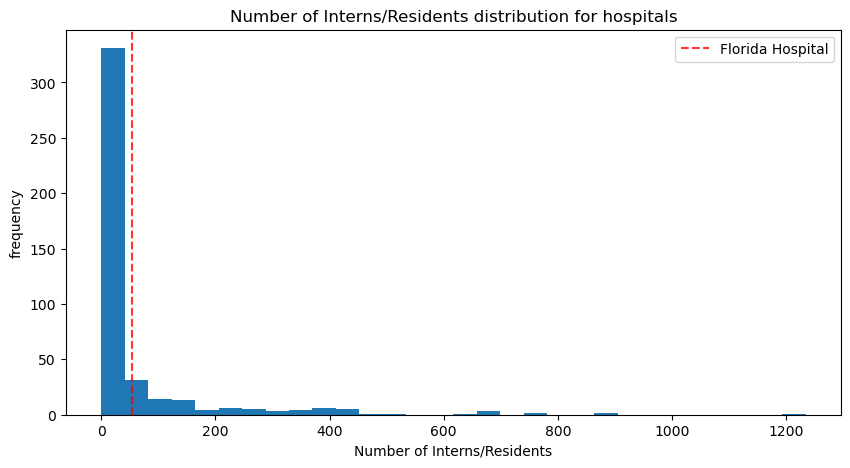

In [190]:
plot_compare('Number of Interns and Residents (FTE)', 'Number of Interns/Residents')

Our Random Florida Hospital seems to have at least some interns/residents. This is something that our hospital could improve.

### 7.8.8 Hospital Days<a id='7.8.8_Hospital_Days'></a>

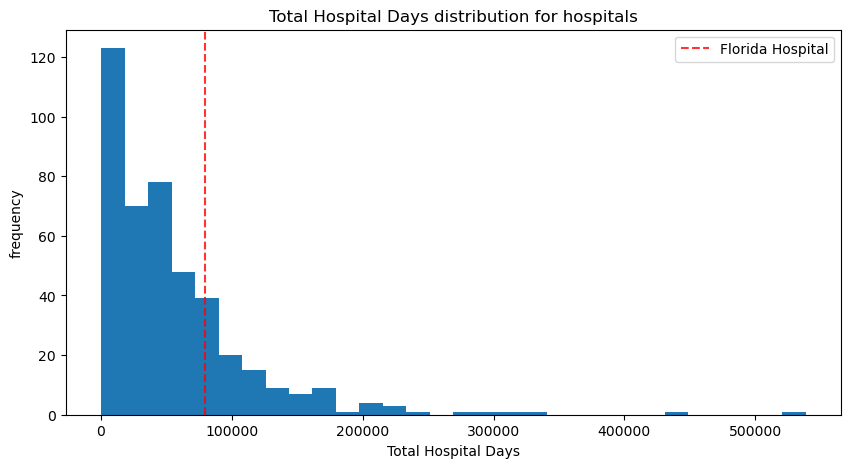

In [191]:
plot_compare('Hospital Total Days (V + XVIII + XIX + Unknown) For Adults &amp; Peds', 'Total Hospital Days')

Our hospital has decent demand given its hospital days. This is harder to improve without acquiring more facilities or acquiring other hospitals in the area. This is a demand statistic.

## 7.9 Modeling scenarios<a id='7.9_Modeling_scenarios'></a>

Lets run through some scenarios that might be feasible for the hospital to accomplish to increase its price.

The possible options:
1. Increasing PSI 15 by a certain percentage or increase HAI 2 SIR by a certain percentage
2. Increase Demand by certain percentage by acquiring another hospital, either through discharge ratio/hospital days
3. Increase Number of Interns/Residents by a certain percentage
4. Increase all PSI metrics by a certain percentage

In [192]:
all_feats = ['PSI_15', 'HAI_2_SIR', 'Number of Interns and Residents (FTE)', 'bed_ratio', 
             'discharge_ratio', 'Hospital Total Days (V + XVIII + XIX + Unknown) For Adults &amp; Peds']
florida_hospital[all_feats]

,PSI_15,HAI_2_SIR,Number of Interns and Residents (FTE),bed_ratio,discharge_ratio,Hospital Total Days (V + XVIII + XIX + Unknown) For Adults &amp; Peds
58,0.831219,0.346,54.68,0.009348,0.049473,79483.0


In [193]:
def predict_increase(features, deltas):
    bm2 = X_bm.copy()
    for f, d in zip(features, deltas):
        bm2[f] *= (1 + d)
    return model.predict(bm2).item() - model.predict(X_bm).item()

### 7.9.1 Scenario 1<a id='7.9.1_Scenario_1'></a>

I believe it is reasonable to increase these metrics from 10-40%. Let us take a look at these values.

In [207]:
deltas = [i * 0.1 for i in range(1, 5)]
price_deltas_psi = [predict_increase(['PSI_15'], [delta]) for delta in deltas]
price_deltas_sir = [predict_increase(['HAI_2_SIR'], [delta]) for delta in deltas]

In [208]:
price_deltas_psi

[-3.8212096617100997, -5.994341633280328, 9.244028124834358, 18.10772770777203]

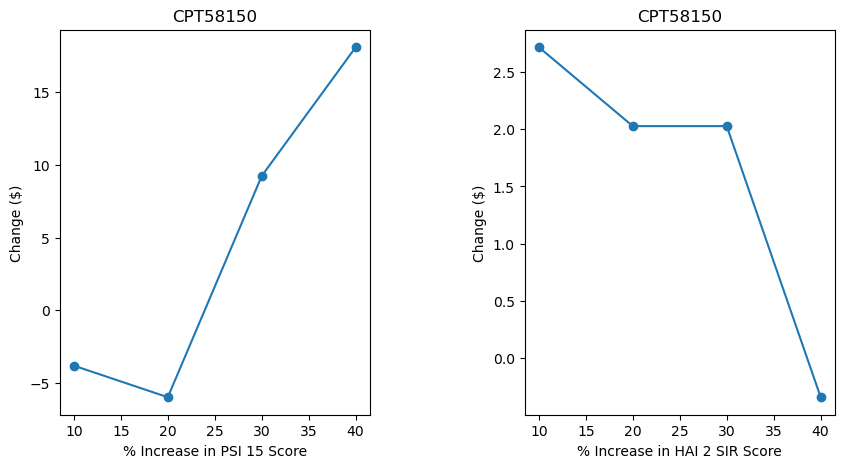

In [210]:
perc_change = [perc*100 for perc in deltas] #1
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.subplots_adjust(wspace=0.5)
ax[0].plot(perc_change, price_deltas_psi, 'o-')
ax[0].set(xlabel='% Increase in PSI 15 Score', ylabel='Change ($)', title=procedure)
ax[1].plot(perc_change, price_deltas_sir, 'o-')
ax[1].set(xlabel='% Increase in HAI 2 SIR Score', ylabel='Change ($)', title=procedure);

It seems like we would need to increase PSI by at least 30% based on this model, which may be difficult, to see a price increase. Our hospital is already near the top end when it comes to HAI 2, this is why their is barely a change in our model.

### 7.9.2 Scenario 2<a id='7.9.2_Scenario_2'></a>

In this Scenario we are looking at demand metrics that are cost intensive for the hospital and hard for them to control given the nature of medicine.

In [197]:
hosp_days_increase = [predict_increase(['Hospital Total Days (V + XVIII + XIX + Unknown) For Adults &amp; Peds'], [delta]) for delta in deltas]
discharge_ratio_increase = [predict_increase(['discharge_ratio'], [delta]) for delta in deltas]

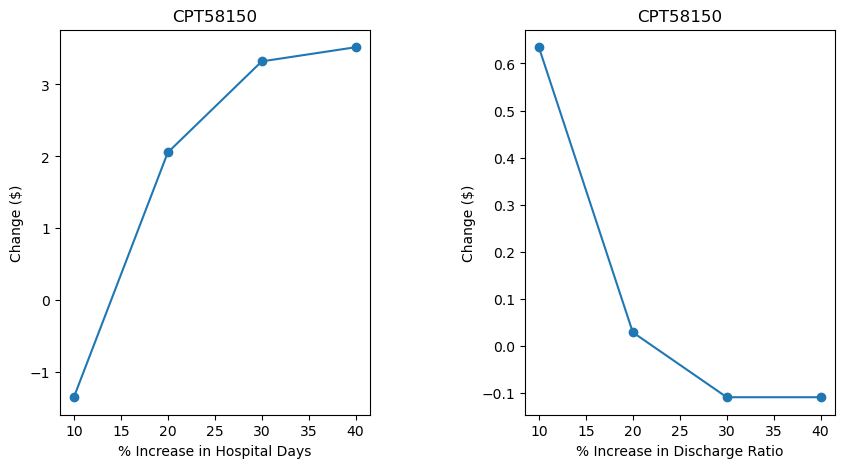

In [198]:
perc_change = [perc*100 for perc in deltas] #1
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.subplots_adjust(wspace=0.5)
ax[0].plot(perc_change, hosp_days_increase, 'o-')
ax[0].set(xlabel='% Increase in Hospital Days', ylabel='Change ($)', title=procedure)
ax[1].plot(perc_change, discharge_ratio_increase, 'o-')
ax[1].set(xlabel='% Increase in Discharge Ratio', ylabel='Change ($)', title=procedure);

The change is marginal for hospital days. This does not look promising, nor something that the hospital can control easily. This might be an option to avoid.

### 7.9.3 Scenario 3<a id='7.9.3_Scenario_3'></a>

In this scenario, we can increase the number of interns that the hospital recruits from the CMS.

In [199]:
intern_increase = [predict_increase(['Number of Interns and Residents (FTE)'], [delta]) for delta in deltas]

In [200]:
for p,delta in enumerate(deltas):
    print(f'This scenario increases discharge ratio by {delta*100:.0f} % for procedure price by ${intern_increase[p]:.2f}')

This scenario increases discharge ratio by 10 % for procedure price by $-0.60
This scenario increases discharge ratio by 20 % for procedure price by $-0.02
This scenario increases discharge ratio by 30 % for procedure price by $-0.02
This scenario increases discharge ratio by 40 % for procedure price by $-0.02


Our hospital already has a lot of interns, and increasing the number of interns seems to have little affect on prices.

### 7.9.4 Scenario 4<a id='7.9.4_Scenario_4'></a>

In [213]:
price_deltas_combo = [predict_increase(['PSI_15','PSI_08','PSI_11','PSI_13','PSI_12'], 
                                       [delta, delta, delta, delta, delta]) for delta in deltas]

In [214]:
for p,delta in enumerate(deltas):
    print(f'This scenario increases in all PSI metrics by {delta*100:.0f} % for procedure price by ${price_deltas_combo[p]:.2f}')

This scenario increases in all PSI metrics by 10 % for procedure price by $-6.34
This scenario increases in all PSI metrics by 20 % for procedure price by $0.48
This scenario increases in all PSI metrics by 30 % for procedure price by $18.16
This scenario increases in all PSI metrics by 40 % for procedure price by $30.98


This seems to have a much more dramatic increase on prices.

## 7.10 Summary<a id='7.10_Summary'></a>

Using the model created from the prior notebook, predictions were made about price for CPT 58150 (under anesthesia hysterectomy procedure) for our random Florida hospital.
First, a prediction using the current features using this model resulted in a price of $1392.49, actual price is $1427.87. According to this model, we are close to the actual price and witin the MAE.

Taking a step back, we explored features of our random hospital and compared them to other hospitals, particularly for the features selected by our random forest model. We tend to be slightly beloow the mode or near the mode on most features compared to other hospitals. 

The potential scenarios we explored:
1. Increasing PSI 15 by a certain percentage or increase HAI 2 SIR by a certain percentage
2. Increase Demand by certain percentage by acquiring another hospital, either through discharge ratio/hospital days
3. Increase Number of Interns/Residents
4. Increase both PSI 15 and HAI 2 by a certain percentage

We accounted for each of these scenarios to determine the new price to be charged:

**For scenario 1:** The model supported this outcome, particularly PSI 15 metric. However the price change would be minimal.

**For scenario 2:** The model did not support this outcome and it would be extremely costly.

**For scenario 3:** The model did not support this outcome, as it would make little change to price of the procedure.

**For scenario 4:** The model supported this outcome, especially if increasing all PSI metrics by +30% or more.

Scenario 4 seems the most appealing to me. Increasing all PSI metrics go hand in hand and hospitals would be required to implement similar measures to increase all metrics. In addition, we did not account for decreases in HAI values, which would probably decrease as well with any hospital implementation of these metrics. However, our hospital seems to be doing well in their metrics.

## 7.11 Further work<a id='7.11_Further_work'></a>

There were certain limitations to the work done. First, looking at the data, I was not able to parse all the values from the JSON files just due to processing power. We were limited in areas where these prices came from, mostly from the state of Florida. In addition, we limited the procedures to look at. The datasets were matched on different time periods given the limitations of this analysis.

Additionally, our model did not have great accuracy, at around 79%. I believe a deeper model might be able to predict the prices at a better rate. Our predictions on how prices affect revenue limits our analysis on what decision is best. But this does show proof of concept.

This model could be used by our client for other parameter changes and we could set-up a new Jupyter notebook where one could set the parameters in one cell for other procedures.